In [121]:
# import math functions
from math import sqrt

# import numpy functions
from numpy import (
    vectorize, linspace, logspace, arange, zeros, log10, fill_diagonal, 
    exp, pi, set_printoptions, log2, inf, array, ndarray, diagonal,
    cos, sqrt as nsqrt, log, finfo, power
)
from numpy.linalg import solve, norm, inv, eigvals


import sys

# set to print lines to large width
set_printoptions(linewidth=500)

from itertools import cycle

%matplotlib inline
from matplotlib.style import use
use("seaborn")

# import the default plot settings
from pltconfig import *

# Problem 4

## Part A

In [126]:
# def the exact solution
def exact_soln(x, epsilon=1.0):
    cofactor = exp(1-x)/(exp(1)-1)
    if (abs(epsilon-1.0) < finfo('float32').eps):
        return -cofactor*(exp(x)-exp(1)*x+x-1)
    else:
        cofactor = exp(-x)/((epsilon-1)*(power(exp(1),1/epsilon)-1))
        return cofactor*(
            exp((1/epsilon)+x)
            - exp(((epsilon-1)*x+1)/epsilon) 
            + exp((((epsilon-1)*x)/epsilon)+(1./epsilon)+1)
            - exp((1/epsilon)+1)
            - exp(x+1)
            + exp(1)
        )

## Part B

In [104]:
class q4b(object):
    
    def __init__(self, a=0.0, b=1.0, m=50, alpha=0.0, beta=0.0, epsilon=1.0):
        self.a = a
        self.b = b
        self.m = m
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon
        self.h = (b-a)/(m+1) # step size
        self.xpts = a + (arange(m+2))*self.h
        self.A = self.construct_A()
        self.F = self.construct_F()
        self.U = self.get_U()
        self.U_thomas = self.get_U_from_Thomas()
    
    def get_all_parameters (self):
        return self.a, self.b, self.m, self.h, self.xpts
    
    def construct_A(self):
    
        # get parameters
        m = self.m
        h = self.h
        epsilon = self.epsilon
    
        # Initialize the matrix A
        A = zeros((m+2, m+2))
        # First define the matrix A
        # define the lower and upper diagonals, respectively
        fill_diagonal(A[2:-1,1:-1], (2*epsilon-h)); fill_diagonal(A[1:,2:-1], (2*epsilon+h))
        # define the on-diagonal terms
        fill_diagonal(A[1:-1,1:-1], -4*epsilon)
        # fill_diagonal(A[1:-1,1:-1], -2.0)
        # define the left-hand boundaries
        A[0,0] = 1.0; A[1,0] = 1.0
        # define the right-hand boundaries
        A[-2,-1] = 1.0; A[-1, -2] = 0.0; A[-1,-1] = 1.0
        # scale entire matrix by 1./h^2
        A *= 1./(2*h*h)

        return A
    
    def get_Ainv(self):
        
        A = self.construct_A()
        
        return inv(A)
    
    def construct_F(self):
        
        # get parameters
        m = self.m
        h = self.h
        alpha = self.alpha
        beta = self.beta
        xpts = self.xpts
    
        # initialize the right-hand side
        F = zeros(m+2)
        # define the RHS in the interior of the domain
        F[1:-1] = -exp(1-xpts[1:-1])
        # define the LHS and RHS boundary terms, respectively
        F[0] = alpha/(h*h); F[-1] = beta/(h*h)
        
        return F
    
    def get_U(self):  
        return solve(self.A,self.F)
    
    # use Thomas algorithm to implement triadiagonal matrix algorithm
    # derived from: https://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)

    def get_U_from_Thomas(self):

        # create copies of arrays so original arrays are not modified
        _a = diagonal(self.A,-1).copy()
        _b = diagonal(self.A).copy()
        _c = diagonal(self.A,1).copy()
        _d = self.F.copy()
        
        # determine the number of equations
        n_eqns = _d.size
        
        # forward sweep
        for i in range(1, n_eqns):
            m = _a[i-1]/_b[i-1]
            _b[i] = _b[i] - m*_c[i-1] 
            _d[i] = _d[i] - m*_d[i-1]

        # back-substitution sweep
        soln = _b
        soln[-1] = _d[-1]/_b[-1]
        for j in range(n_eqns-2, -1, -1):
            soln[j] = (_d[j]-_c[j]*soln[j+1])/_b[j]

        return soln
    
    def get_plot(self):
        
        fig, ax = subplots(1,1, figsize=(10,10))
        ax.plot(self.xpts, self.U, lw=3.0)

        ax.set_ylabel(r"$U[x]$", fontsize=28)
        ax.set_xlabel(r"$x$", fontsize=28)
        ax.tick_params(labelsize=24)
        ax.grid(True)
        
        fig.tight_layout()
        fig.savefig("q4b_fig.pdf")

In [155]:
def q4b_compute_grid_error_scaling(n=9):
    
        # initialize array for storage
        hvals = zeros(n)
        error_array1_2norm = zeros(n)
        error_array2_2norm = zeros(n)
        error_array1_infnorm = zeros(n)
        error_array2_infnorm = zeros(n)

        # set the number of initial number of internal points
        m_coarse = (2**2)
        # solve on initial mesh
        soln_coarse = q4b(m=m_coarse)

        print(f"m    h        2-norm error  inf-norm error  ratio (2-norm)  ratio (inf-norm)  order (2-norm)  order (inf-norm)")
        
        for i in range(n):
            
            # record the spacing
            hvals[i] = soln_coarse.h
            
            # compute the errors using the grid-2norm
            error_array1_2norm[i] = sqrt(soln_coarse.h)*norm(soln_coarse.U_thomas-exact_soln(soln_coarse.xpts), ord=2)

            # compute the errors using the infinity-norm
            error_array1_infnorm[i] = norm(soln_coarse.U_thomas-exact_soln(soln_coarse.xpts), ord=inf)

            # define the finer grids
            m_fine = 2*m_coarse + 1

            # construct the finer mesh and solve 
            soln_fine = q4b(m=m_fine)

            # set the current fine grid as the coarse grid for next iteration
            m_coarse = m_fine 
            soln_coarse = soln_fine
            
            if (i > 0):
                print(
                    f"{m_coarse:<5d}"
                    + f"{hvals[i]:<9.5f}"
                    + f"{error_array1_2norm[i]:<14.2e}"
                    + f"{error_array1_infnorm[i]:<16.2e}"
                    + f"{error_array1_2norm[i]/error_array1_2norm[i-1]:<16.5f}"
                    + f"{error_array1_infnorm[i]/error_array1_infnorm[i-1]:<18.5f}"
                    + f"{-log((error_array1_2norm[i]/error_array1_2norm[i-1]).__abs__())/log(2):<16.5f}"
                    + f"{-log((error_array1_infnorm[i]/error_array1_infnorm[i-1]).__abs__())/log(2):<16.5f}"
                    )
            else:
                print(
                    f"{m_coarse:<5d}"
                    + f"{hvals[i]:<9.5f}"
                    + f"{error_array1_2norm[i]:<14.2e}"
                    + f"{error_array1_infnorm[i]:<16.2e}"
                    )

        return hvals, error_array1_2norm, error_array1_infnorm

In [156]:
def plot_4b():
    
    hvals, error_array1_2norm, error_array1_infnorm = q4b_compute_grid_error_scaling()

    fig, ax = subplots(1,1,figsize=(10,10))

    ax.loglog(hvals, error_array1_2norm, lw=3.0, label="2-norm")
    ax.loglog(hvals, error_array1_infnorm, lw=3.0, label="inf-norm")

    ax.loglog(hvals, 10*hvals*hvals, lw=3.0, ls="--", color="gray", label=r"reference $h^{2}$ line")
    
    ax.legend(loc=0, prop={"size":18})
    ax.set_ylabel(r"$E(h)$", fontsize=28)
    ax.set_xlabel(r"$h$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q4b_fig.pdf")

m    h        2-norm error  inf-norm error  ratio (2-norm)  ratio (inf-norm)  order (2-norm)  order (inf-norm)
9    0.20000  4.82e-04      6.78e-04        
19   0.10000  1.20e-04      1.68e-04        0.24873         0.24826           2.00735         2.01007         
39   0.05000  2.99e-05      4.20e-05        0.24960         0.24957           2.00234         2.00251         
79   0.02500  7.48e-06      1.05e-05        0.24989         0.25038           2.00062         1.99779         
159  0.01250  1.87e-06      2.63e-06        0.24997         0.24997           2.00016         2.00016         
319  0.00625  4.68e-07      6.58e-07        0.24999         0.25001           2.00004         1.99995         
639  0.00313  1.17e-07      1.64e-07        0.25000         0.25000           2.00001         1.99999         
1279 0.00156  2.92e-08      4.11e-08        0.25000         0.25000           2.00000         1.99999         
2559 0.00078  7.31e-09      1.03e-08        0.25011         0.25011

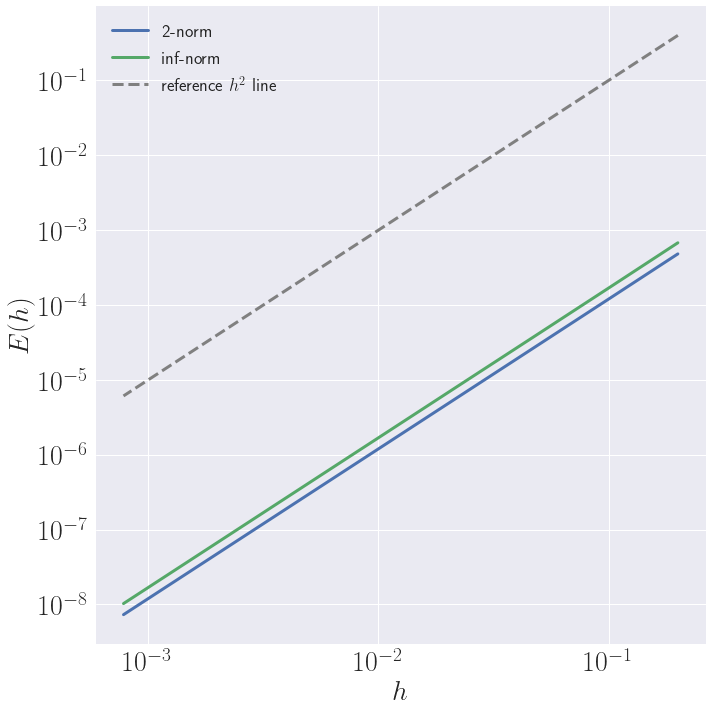

In [157]:
plot_4b()

## Part C

In [108]:
class q4c(q4b):
    
    def __init__(self, a=0.0, b=1.0, m=50, alpha=0.0, beta=0.0, epsilon=1.0):
        self.a = a
        self.b = b
        self.m = m
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon
        self.h = (b-a)/(m+1) # step size
        self.xpts = a + (arange(m+2))*self.h
        self.A = self.construct_A()
        self.F = self.construct_F()
        self.U = self.get_U()
        self.U_thomas = self.get_U_from_Thomas()
    
    def construct_F(self):
        
        # get parameters
        m = self.m
        h = self.h
        alpha = self.alpha
        beta = self.beta
        xpts = self.xpts
    
        # initialize the right-hand side
        F = zeros(m+2)
        # define the RHS in the interior of the domain with deffered corrections
        F[1:-1] = -(exp(1-(arange(1,m+1)*h))/12)*(12+h*h)
        # define the LHS and RHS boundary terms, respectively
        F[0] = alpha/(h*h); F[-1] = beta/(h*h)
        
        return F
    
    def get_plot(self):
        
        fig, ax = subplots(1,1, figsize=(10,10))
        ax.plot(self.xpts, self.U, lw=3.0)

        ax.set_ylabel(r"$U[x]$", fontsize=28)
        ax.set_xlabel(r"$x$", fontsize=28)
        ax.tick_params(labelsize=24)
        ax.grid(True)
        
        fig.tight_layout()
        fig.savefig("q4c_fig.pdf")

In [149]:
def q4c_compute_grid_error_scaling(n=9):
    
        # initialize array for storage
        hvals = zeros(n)
        error_array1_2norm = zeros(n)
        error_array2_2norm = zeros(n)
        error_array1_infnorm = zeros(n)
        error_array2_infnorm = zeros(n)

        # set the number of initial number of internal points
        m_coarse = (2**2)
        # solve on initial mesh
        soln_coarse = q4c(m=m_coarse)

        print(f"m    h        2-norm error  inf-norm error  ratio (2-norm)  ratio (inf-norm)  order (2-norm)  order (inf-norm)")
        
        for i in range(n):
            
            # record the spacing
            hvals[i] = soln_coarse.h
            
            # compute the errors using the grid-2norm
            error_array1_2norm[i] = sqrt(soln_coarse.h)*norm(soln_coarse.U_thomas-exact_soln(soln_coarse.xpts), ord=2)

            # compute the errors using the infinity-norm
            error_array1_infnorm[i] = norm(soln_coarse.U_thomas-exact_soln(soln_coarse.xpts), ord=inf)

            # define the finer grids
            m_fine = 2*m_coarse + 1

            # construct the meshes and solve 
            soln_fine = q4c(m=m_fine)

            # set the current fine grid as the coarse grid for next iteration
            m_coarse = m_fine 
            soln_coarse = soln_fine
            
            if (i > 0):
                print(
                    f"{m_coarse:<5d}"
                    + f"{hvals[i]:<9.5f}"
                    + f"{error_array1_2norm[i]:<14.2e}"
                    + f"{error_array1_infnorm[i]:<16.2e}"
                    + f"{error_array1_2norm[i]/error_array1_2norm[i-1]:<16.5f}"
                    + f"{error_array1_infnorm[i]/error_array1_infnorm[i-1]:<18.5f}"
                    + f"{-log((error_array1_2norm[i]/error_array1_2norm[i-1]).__abs__())/log(2):<16.5f}"
                    + f"{-log((error_array1_infnorm[i]/error_array1_infnorm[i-1]).__abs__())/log(2):<16.5f}"
                    )
            else:
                print(
                    f"{m_coarse:<5d}"
                    + f"{hvals[i]:<9.5f}"
                    + f"{error_array1_2norm[i]:<14.2e}"
                    + f"{error_array1_infnorm[i]:<16.2e}"
                    )

        return hvals, error_array1_2norm, error_array1_infnorm

In [150]:
def plot_4c():
    
    hvals, error_array1_2norm, error_array1_infnorm = q4c_compute_grid_error_scaling()

    fig, ax = subplots(1,1,figsize=(10,10))

    ax.loglog(hvals, error_array1_2norm, lw=3.0, label="2-norm")
    ax.loglog(hvals, error_array1_infnorm, lw=3.0, label="inf-norm")

    ax.loglog(hvals, 10*hvals*hvals, lw=3.0, ls="--", color="gray", label=r"reference $h^{2}$ line")
    
    ax.legend(loc=0, prop={"size":18})
    ax.set_ylabel(r"$E(h)$", fontsize=28)
    ax.set_xlabel(r"$h$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q4c_fig.pdf")

m    h        2-norm error  inf-norm error  ratio (2-norm)  ratio (inf-norm)  order (2-norm)  order (inf-norm)
9    0.20000  9.83e-04      1.37e-03        
19   0.10000  2.45e-04      3.41e-04        0.24922         0.24883           2.00448         2.00677         
39   0.05000  6.12e-05      8.52e-05        0.24974         0.24971           2.00153         2.00168         
79   0.02500  1.53e-05      2.13e-05        0.24993         0.24993           2.00041         2.00042         
159  0.01250  3.82e-06      5.33e-06        0.24998         0.24998           2.00010         2.00011         
319  0.00625  9.55e-07      1.33e-06        0.25000         0.25000           2.00003         2.00003         
639  0.00313  2.39e-07      3.33e-07        0.25000         0.25000           2.00001         2.00000         
1279 0.00156  5.97e-08      8.32e-08        0.25000         0.25000           2.00000         1.99999         
2559 0.00078  1.49e-08      2.08e-08        0.25006         0.25006

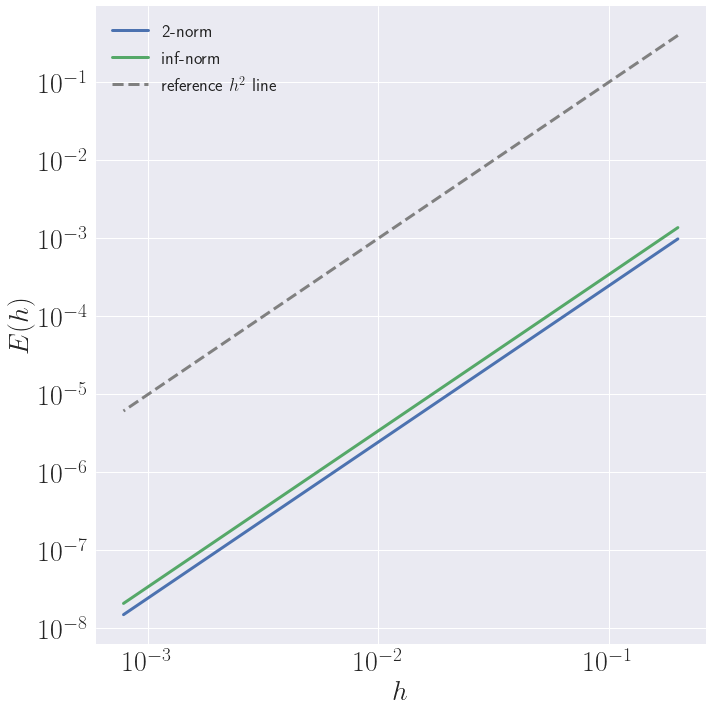

In [151]:
plot_4c()

In [112]:
class q4d(q4b):
    
    def __init__(self, a=0.0, b=1.0, m=50, alpha=0.0, beta=0.0, epsilon=1.0):
        self.a = a
        self.b = b
        self.m = m
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon
        self.h = (b-a)/(m+1) # step size
        self.xpts = a + (arange(m+2))*self.h
        self.A = self.construct_A()
        self.F = self.construct_F()
        self.U = self.get_U()
        self.U_thomas = self.get_U_from_Thomas()
    
    def get_plot(self):
        
        fig, ax = subplots(1,1, figsize=(10,10))
        ax.plot(self.xpts, self.U, lw=3.0)

        ax.set_ylabel(r"$U[x]$", fontsize=28)
        ax.set_xlabel(r"$x$", fontsize=28)
        ax.tick_params(labelsize=24)
        ax.grid(True)
        
        fig.tight_layout()
        fig.savefig("q4d_fig.pdf")

In [113]:
def plot_4d():
    
    m_coarse = 2**4
    m_fine = 2*m_coarse + 1
    m_vfine = 2*m_fine + 1
    
    # prepare different meshes
    Ui = q4d(m=m_coarse)
    V = q4d(m=m_fine)
    W = q4d(m=m_vfine)
    
    V2i = V.U[::2].copy()
    W4i = W.U[::4].copy()
    
    U_extrapolate = (64.0/45.0)*W4i-(4.0/9.0)*V2i+(1.0/45.0)*Ui.U
    
    fig, ax = subplots(1,1,figsize=(10,10))

    ax.plot(Ui.xpts, exact_soln(Ui.xpts), "-", color="black", lw=3.0)
    ax.plot(Ui.xpts, U_extrapolate, "ro", lw=3.0)
    
    ax.set_ylabel(r"$\tilde{U}(x)$", fontsize=28)
    ax.set_xlabel(r"$x$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q4d_fig.pdf")

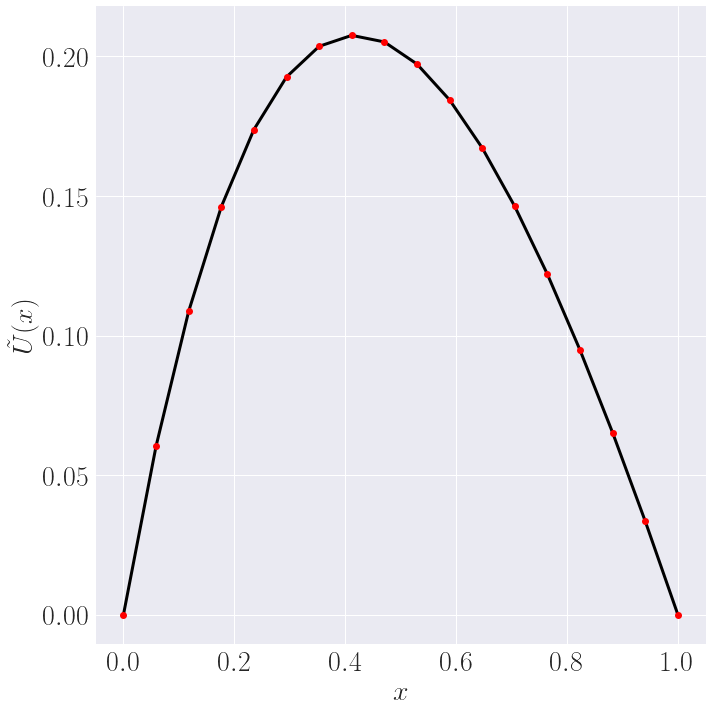

In [114]:
plot_4d()

In [117]:
class q4e(q4b):
    
    def __init__(self, a=0.0, b=1.0, m=50, alpha=0.0, beta=0.0, epsilon=0.01):
        self.a = a
        self.b = b
        self.m = m
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon
        self.h = (b-a)/(m+1) # step size
        self.xpts = a + (arange(m+2))*self.h
        self.A = self.construct_A()
        self.F = self.construct_F()
        self.U = self.get_U()
        self.U_thomas = self.get_U_from_Thomas()
    
    def get_plot(self):
        
        fig, ax = subplots(1,1, figsize=(10,10))
        ax.plot(self.xpts, self.U, lw=3.0)

        ax.set_ylabel(r"$U[x]$", fontsize=28)
        ax.set_xlabel(r"$x$", fontsize=28)
        ax.tick_params(labelsize=24)
        ax.grid(True)
        
        fig.tight_layout()
        fig.savefig("q4d_fig.pdf")

In [141]:
def plot_4e():
    
    epsilon = 0.01
    
    m_coarse = 2**4
    
    
    fig, ax = subplots(1,1,figsize=(10,10))

    ax.plot(linspace(0.0, 1.0, int(1e6)), exact_soln(linspace(0.0, 1.0, int(1e6)), epsilon=0.01), color="black", lw=5.0, label="Exact")
    
    for i in range(4):
        # iterate through the meshes different meshes
        soln = q4d(m=m_coarse, epsilon=0.01)
        
        ax.plot(soln.xpts, soln.U, ls="--", lw=3.0, label=f"{m_coarse}")
        
        m_coarse = 2*m_coarse + 1
    
    ax.legend(loc=0, prop={"size":20}, title=r"$m$", title_fontsize=20)
    ax.set_ylabel(r"$U(x)$", fontsize=28)
    ax.set_xlabel(r"$x$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q4e_fig.pdf")

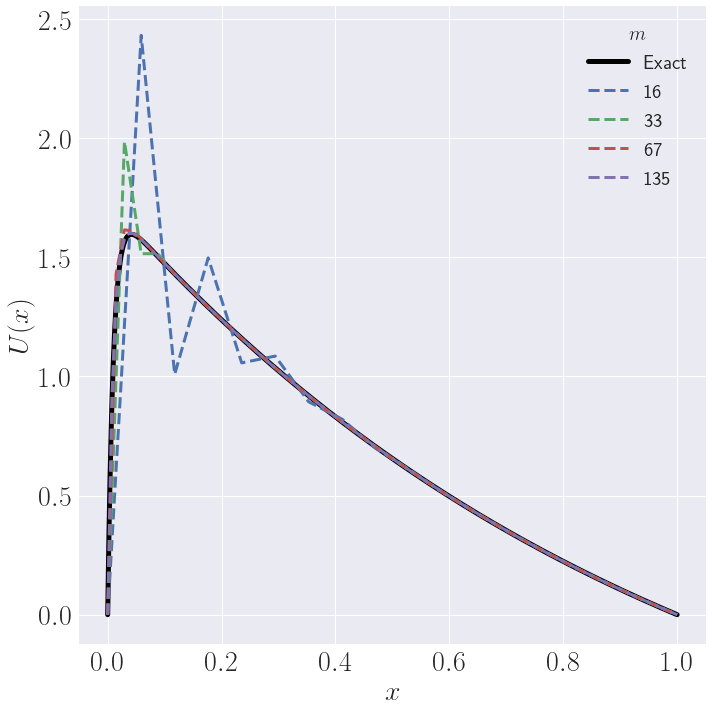

In [142]:
plot_4e()